# 23 - Classifying All-NBA Players (Part V - Decision Tree)
Alrighty, so we've taken a look at the following classifiers: Manually selected linear boundary, LDA, QDA, and logistic regression. First one, not so scientific. Next 3, a bit of math involved, nothing too crazy. We now jump to one of the most interpretable models that exist. [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/download.html) calls the decision tree as close to an off-the-shelf model you can get.

According to the book, trees have the following outstanding qualities:
- Fast to construct
- Interpretable models (if trees are relatively small)
- Can naturally incorporate numeric and categorical featuers
- Immune to outliers
- Perform internal feature selection

The only thing that prevents decision trees from being completely ideal is accuracy because they seldom provide the predictive accuracy compared to the best that can be achieved with the data at hand. This really depends on what your application here is, though. For many applications, _**interpretability**_ may be just as, if not more important, if not _**A LOT**_ more important than accuracy alone. In an application like we're exploring now, where we're literally trying to make sense of how VORP and WS affects all-NBA status, we'd likely welcome something that says "hey bozo, anything over a WS of 7 generally makes all-NBA". This contrasts to something like Neural Networks, which we'll look at later, but generally is a very complex linear combination of the inputs and usually is very complex. For much more complex applications like image detection, NN's have become more popular because of their flexibility, but if you try to interpret the model to understand how the NN is telling the difference between a picture of a meerkat and a picture of a lion, you'd be hard-pressed to find an explanation that someone else will also be able to understand!

Now, back to trees. Essentially what we're trying to do is split our space up with basic logic / rules that an analyst might come up with. Let's say we're trying to figure out peoples' salaries based on their education. Maybe you'd say somebody with no post secondary education might have a lower salary. Perhaps someone with 0-4 years of schooling will have a bit higher salary. 4-8 even more. And maybe 8-12 is too much school and your salary goes down a bit (you stay in academia or something like that). Your rules might look like:
- If # years schooling == 0: Salary ~ \$40K
- If 0 < # years schooling < 4: Salary ~ \$80K
- If 4 < # years schooling < 8: Salary ~ \$120K
- If 8 < # years schooling < 12: Salary ~ \$80K

If we extended this to 2 features, maybe our 2D space would look something like that:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/trees/1exampleregions.png)

And if we broke down the rules, our rules could be mapped out in a plot like this:

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/trees/2exampletree.png)

The above two plots are saying the same thing!

From this graphic in [ISL](http://www-bcf.usc.edu/~gareth/ISL/) (ESL's more application-based sister book), we can see further advantages and drawbacks of the decision tree.

![](https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/images/trees/3treelinearboundary.png)

We see for linear boundaries, linear models could work better. For non-linear and more compartmentalized boundaries, decision trees can perform well. Decision trees can perform well for linear boundaries as well, but like the top-right plot above, we see our decision tree becomes more complicated and to an extent less interpretable.

We actually do have more of a linear boundary here, so the decision tree might not be the _**best**_ model, but let's see what happens.

In [1]:
# Load libraries & initial config
%load_ext rpy2.ipython

%R library(ggplot2)
%R library(gridExtra)
%R library(scales)
%R library(ggbiplot)
%R library(dplyr)

%matplotlib nbagg
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import boto3
from StringIO import StringIO
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Retrieve team stats from S3
playerAggDfAllNbaAllStar = pd.read_csv('https://s3.ca-central-1.amazonaws.com/2017edmfasatb/fas_boto/data/playerAggDfAllNbaAllStar.csv', index_col = 0)

pd.set_option('display.max_rows', len(playerAggDfAllNbaAllStar.dtypes))
print playerAggDfAllNbaAllStar.dtypes
pd.reset_option('display.max_rows')

season_start_year          int64
perGameStats_Player       object
perGameStats_Pos          object
perGameStats_Age           int64
perGameStats_Tm           object
perGameStats_G             int64
perGameStats_GS          float64
perGameStats_MP          float64
per100Stats_FG           float64
per100Stats_FGA          float64
per100Stats_FGPerc       float64
per100Stats_3P           float64
per100Stats_3PA          float64
per100Stats_3PPerc       float64
per100Stats_2P           float64
per100Stats_2PA          float64
per100Stats_2PPerc       float64
per100Stats_FT           float64
per100Stats_FTA          float64
per100Stats_FTPerc       float64
per100Stats_ORB          float64
per100Stats_DRB          float64
per100Stats_TRB          float64
per100Stats_AST          float64
per100Stats_STL          float64
per100Stats_BLK          float64
per100Stats_TOV          float64
per100Stats_PF           float64
per100Stats_PTS          float64
per100Stats_ORtg         float64
per100Stat

Let's remind ourselves first what the data looks like.

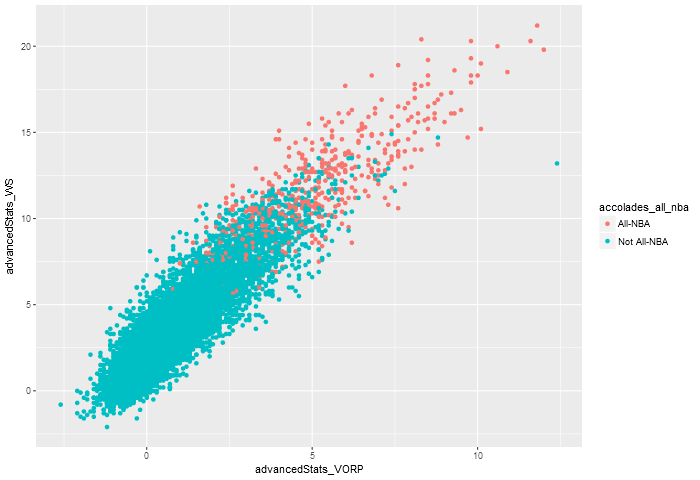

In [3]:
%%R -i playerAggDfAllNbaAllStar -w 700 -u px

# Plot WS vs VORP scatter with predictions colored in
allNbaPlot = ggplot(
    NULL
) +
geom_point(
    data = playerAggDfAllNbaAllStar,
    aes(
        x = advancedStats_VORP,
        y = advancedStats_WS,
        color = accolades_all_nba
    )
)

allNbaPlot

There seems to be a few libraries capable of performing decision trees in R. It seems that the most basic one is simply a package called 'tree'. Let's give it a go.

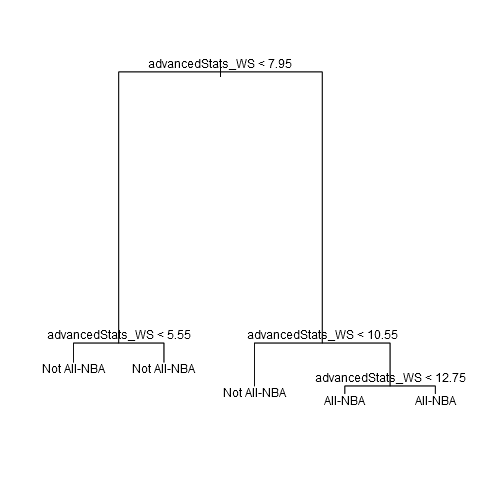

LookupError: 'treeModelSummary' not found

In [4]:
%%R -i playerAggDfAllNbaAllStar -o treeModel -o treeModelSummary
library(tree)

# Build a tree using the 'tree' function
treeModel = tree(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, 
    data = playerAggDfAllNbaAllStar
)

# Plot the tree
plot(treeModel)
text(treeModel)

Alright, so we've got a tree. First thing I notice here right off the bat... where's VORP? We're wanting to build a model off of WS and VORP right? Well where is it? My first instinct seeing the tree is that... well... does VORP not matter in the presence of WS? It seems that, from the tree, a WS > 10.55 will get you onto an all-NBA team. With the eye test, this seems to pass. WS = 10.55 is the line about where the blues start to fade out and pinks start to come in (in our first plot).

Second observation... certain terminal nodes actually repeat themselves. For example, if we look at the WS > 10.55 guys, the tree splits further into WS < 12.75 and WS > 12.75... except the problem here is that both of them lead to All-NBA! What's the point of even making that last WS = 12.75 split if both of them lead to All-NBA? Can't we just leave it at WS > 10.55 leads to All-NBA?

My last thought is... why did we stop at 5 terminal nodes? I like the tree and all, but tying into our last point, why not 4 terminal nodes, or better yet, 6 terminal nodes? 100 terminal nodes? 1000 terminal nodes? I know from reading about trees that we can have a ton of nodes and overfit the hell out of this model. Why did we get such a (seemingly) reasonable tree here?

To recap all my concerns:
1. Where's VORP?
2. Why do splits lead to same results in terminal nodes?
3. Why did the tree splits stop where they stopped?

Let's park 1. for now and look a bit more at 2. and 3.

From reading about trees in [ESL](http://statweb.stanford.edu/~tibs/ElemStatLearn/download.html), I have a basic understanding of how trees are measured in terms of accuracy. To get into this discussion, we have to explore a few options first of how exactly to measure node accuracy or "purity".

Our classic vanilla method of measuring "accuracy" in classification in simply _**misclassification error**_. Simply a count of how many are right and how many are wrong.

$$E=1-max(\hat{p}_{mk})$$

where $\hat{p}_{mk}$ is the proportion of training observations in the $m$th region from the $k$th class. Generally, trees are _**not**_ used with misclassification because it doesn't answer the entire question of accuracy. Let's say we have three classes that we're trying to classify (A, B, C), and we get two nodes with the following results:
- Node 1:
    - Class A: 60%
    - Class B: 39%
    - Class C: 1%
- Node 2:
    - Class A: 60%
    - Class B: 20%
    - Class C: 20%

Which node would you say is more "pure"? The first node seems like a pretty good shot at class A, but class B is not too far behind, still capturing 39% of the population. If I told you I had a 39% of getting something right, that's not too far off from a coin flip, right?

The second node seems to give us a lot more confidence in our estimate that the node represents class A. With each of the other classes at 20%, we feel a bit more comfortable going with class A because 20% is like pulling a yellow marble out of a bag with 4 other red marbles. 1/5th of a chance, right?

The kicker here is that both nodes would have _**the same misclassification error**_ because both of them would end up with _**40%**_.

Because of this logic, we tend to go with either the Gini index:

$$G=\sum_{k=1}^{K}\hat{p}_{mk}(1-\hat{p}_{mk})$$

or Cross-Entropy measurement:

$$D=-\sum_{k=1}^{K}\hat{p}_{mk}log{\hat{p}_{mk}}$$

which both measure more node _**purity**_ as values will get smaller as each node becomes more "pure" with one class.

Reviewing our two scenarios again, we would get the following Gini and Entropy values for node 1:

$$G=\sum_{k=1}^{K}\hat{p}_{mk}(1-\hat{p}_{mk})=(0.6)(1-0.6)+(0.39)(1-0.39)+(0.01)(1-0.01)=0.49$$
$$D=-\sum_{k=1}^{K}\hat{p}_{mk}log{\hat{p}_{mk}}=-((0.6)(log0.6)+(0.39)(log0.39)+(0.01)(log0.01))=0.31$$

and the following values for node 2:
$$G=\sum_{k=1}^{K}\hat{p}_{mk}(1-\hat{p}_{mk})=(0.6)(1-0.6)+(0.2)(1-0.2)+(0.2)(1-0.2)=0.56$$
$$D=-\sum_{k=1}^{K}\hat{p}_{mk}log{\hat{p}_{mk}}=-((0.6)(log0.6)+(0.2)(log0.2)+(0.2)(log0.2))=0.41$$

_**ALRIGHT THEN**_. This is slightly embarrassing... it looks like my logic initially was wrong haha. It looks like node 1 _**is actually more pure**_. I guess my logic is counter-intuitive to what the math of Gini and Entropy say. Let's check out the graphs of misclassification error, Gini, and Entropy:

<img src="http://www.bogotobogo.com/python/scikit-learn/images/Entropy/ImpurityIndicesPlot.png" style="width: 400px;"/>

Okay, it looks like the logic kinda checks out. If I map 0.6-0.39-0.01 out on the Gini and Entropy indexes and 0.6-0.2-0.2 as well, it looks like the sum of these values _**would**_ be higher for the 0.6-0.2-0.2 case. I guess Gini and Entropy really value where the proportion is closer to 1 or 0. That 0.01 really lowers the Gini value (it basically has negligible contribution to the entire index value).

Alright, well now that I know a bit more about the types of metrics I can measure trees on, let's see if I can get a bit more understanding about the questions I had.

Looking through the [documentation](https://cran.r-project.org/web/packages/tree/tree.pdf) for the tree function, the default metric tree uses (within its _**split**_ parameter) is "deviance", which is actually equivalent to _**Entropy**_.

Let's check out the deviance for the nodes above:

In [ ]:
# Print the tree branches
print treeModel

Here, I'm getting a chance to see the logic behind how the tree is estimating some of these nodes. I still don't quite understand why there are 5 terminal nodes, but I can see that many of the terminal nodes boast pretty confident probabilities.

The first thing I want to point out again is the overwhelming amount of non all-NBA players. Only 3.8% of the entire population is all-NBA calibre! This can be observed in the "root" node (first one).

The second thing I notice is how high the deviance values are... why are they so high? I only have 2 classes, and each class cannot have a deviance value of over 1... so how are we getting values in the 100's?

After googling a bit, I'm seeing some [sources](http://homepage.stat.uiowa.edu/~rdecook/stat6220/Class_notes/CART.pdf) calculate deviance like:

$$D=-2n_{i}\sum_{k=1}^{K}\hat{p}_{mk}log{\hat{p}_{mk}}$$

where we also multiply by the number of observations in each node and scale by a factor of 2. I won't pretend like I quite understand why we do this now, and after running through some calculations by myself the numbers still don't align completely, but it does get me closer to the value that I'm seeing in the output of the tree function. I'll just accept this for now, assume that the underlying calculation is still based off Cross Entropy, and understand that the smaller the value, the better.

Understanding of Cross Entropy or deviance helps me gauge a bit better why the tree may have stopped growing. I'm going to poke around the documentation a bit more and see if the tree function has some default stop setting.

It turns out that there is a parameter within tree, _**control**_, which sets some default stop values. There are the _**minsize**_ and _**mindev**_ parameters which control the minimum size of each node and the minimum deviance (in terms of % of root node) for the node to be split respectively. The root node has deviance of about ~4200, so we'd expect the each terminal node to be split if it was above 

Let's see what happens when I change these values. Let's lower the threshold on the minimum deviance. In fact, let's just go all the way to 0 and tell the library to grow the whole tree. Whoop de doo!!

In [ ]:
%%R -i playerAggDfAllNbaAllStar -o treeModelMinDev -o treeModelMinDevSummary
library(tree)

# Build a tree using the 'tree' function with mindev = 0, indicating that we want to grow the whole tree
treeModelMinDev = tree(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, 
    data = playerAggDfAllNbaAllStar,
    mindev = 0
)

# Plot the tree
plot(treeModelMinDev)
text(treeModelMinDev)

In [ ]:
# Print the tree branches
print treeModelMinDev

Welp, there are a lot of nodes unsurprisingly. I guess the tree is basically being grown until it literally cannot get any better. It may be a good model, but unfortunately it's likely to overfit (1000+ nodes on a simple possibly linear decision boundary...).

BUT HEY!! THERE'S VORP!!! Although I never anticipated that the model was broken or anything, it warms to my heart to actually _**see**_ VORP on there. I guess this just means that, within the first 5 terminal nodes (as in the first model), VORP simply doesn't matter!

Back to the huge ass tree though, it's common to grow out the full tree, and then _**prune**_ the tree back. A little more about trees first: It's really _**impossible**_ to explore every single combination of tree that exists. There are infinite number of trees that can be fit if we don't care about accuracy. Even if we care about accuracy, we'd still have to explore every single tree to get the sense of how it fits. Generally, trees are fit _**recursively**_ for computational efficiency. A first split is made, then the next split is made after the first one is complete. Once we have grown out a tree, let's say the 1000+ node tree above, we essentially have 1000 sub-trees that we can choose from. One common way to select the best tree is to perform cross validation on each tree to see which one is best. The 'tree' library gives us a built in function to do that!

In [ ]:
%%R -o bestSize
# Run 10-fold CV on our tree model generated from 'tree'
treeModelMinDevCv = cv.tree(treeModelMinDev)

# Plot CV graph
plot(treeModelMinDevCv)

# Get best size
bestSize <- min(treeModelMinDevCv$size[which(treeModelMinDevCv$dev==min(treeModelMinDevCv$dev))])

In [ ]:
# See which number of terminal nodes yields the best tree
print bestSize

In [ ]:
%%R -o treeModelMinDevCvPruned
treeModelMinDevCvPruned <- prune.tree(treeModelMinDev, best = bestSize)

In [ ]:
print treeModelMinDevCvPruned

We end up with the default tree we started with with no VORP (coincidentally). Let's see how this performs in terms of obtaining a prediction and ROC curve.

In [ ]:
%%R
library(ROCR)

# Use the tree library to predict probabilities
treeModelMinDevCvPrunedPred = predict(treeModelMinDevCvPruned)

# Use the ROCR library to build the ROC curve
treePredObj = prediction(as.data.frame(treeModelMinDevCvPrunedPred[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
treeRocEval = performance(treePredObj, 'sens', 'spec')
plot(treeRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(treePredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

The ROC curve here looks _**kind of**_ like the one yielded by logistic regression. I mean, they probably pretty much will all be the same... but this one is a bit more coarse and it doesn't look to hug the top as much. The AUC pretty much says that it's on par with what logistic regression was giving us. Not much difference here!

In [ ]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = treeRocEval@alpha.values[[1]], sens = treeRocEval@x.values[[1]], spec = treeRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

Here, we see a pretty good cutoff for All-NBA. We're sitting at around 95% / 90%, results that logistic regression was showing us as well! Essentially, a few quick splits _**just on WS**_ gets us the same results! How's that for interpretability? Amazing.

Let's just try out another decision tree package. There seems to be a pretty nice visual package under the 'party' library. From what I've seen of it, it's got a more intuitive decision gree graph where you can see the node sizes and node purity without printing out the text rendition of the tree. Let's give it a shot.

In [ ]:
%%R -w 1500 -u px
library('party')

# Build tree using the ctree tool within the party package
ctreeModel = ctree(
    accolades_all_nba ~ advancedStats_WS + advancedStats_VORP, 
    data = playerAggDfAllNbaAllStar
)

# Plot tree
plot(ctreeModel)

Alright, well this default tree is much different than our other default tree (using default model parameters) generated by the 'tree' package. First of all, VORP is the _**first**_ split! Our other one didn't even have VORP, period! Not only that, but there are many more nodes as well.

The visuals here are definitely much better, we see nodes clearly labelled, the decision rules clearly labelled, and we immediately get a sense of node purity here.

Other than nodes 15 and 20, where we only have a total of ~200 samples out of 13220 (~1% of all samples), all other terminal nodes are pretty pure! The following 2 scenarios lead to successful all-NBA predictions:
- VORP > 4.4, WS > 10.5
- VORP <= 4.4, WS > 11.7

In fact, that first rule is honestly a lot like the manual box boundary that we chose in post \#19! We arbitrarily chose WS > 5 and VORP > 10 then, not too far off from what we're getting now!

Let's check the ROC on this real quick.

In [ ]:
%%R
# Use the tree library to predict probabilities
cTreeModelPred = predict(ctreeModel, type = 'prob')

# Predict on ctree returns a list of vectors instead of a data frame, we convert to dataframe here
cTreeModelPredDf = do.call(rbind, cTreeModelPred)

# Use the ROCR library to build the ROC curve
cTreePredObj = prediction(as.data.frame(cTreeModelPredDf[,1]), ifelse(playerAggDfAllNbaAllStar['accolades_all_nba'] == 'All-NBA', TRUE, FALSE))

# Run performance evaluation for the metric 'total accuracy'
cTreeRocEval = performance(cTreePredObj, 'sens', 'spec')
plot(cTreeRocEval, colorize = T)
text(
    0.2, 
    0.08, 
    labels = paste("AUC = ", round(performance(cTreePredObj, 'auc')@y.values[[1]], digits = 4), sep= ""), 
    adj = 1
)

In [ ]:
# Retrieve the iterative cut-off sensitivity analysis that logistic regression did behind the scenes
%R cutoffs = data.frame(cut = cTreeRocEval@alpha.values[[1]], sens = cTreeRocEval@x.values[[1]], spec = cTreeRocEval@y.values[[1]])

# Calculate the metrics sensitivity + specificity. This will help us gauge the accuracy of both classes simultaneously.
#   E.g. if we were guessing each class 100% correctly (there is a very distinct decision boundary), then we would have 1 + 1 = 2
%R cutoffs['sens_plus_spec'] = cutoffs['sens'] + cutoffs['spec']

# See the last few rows of this dataframe where the sensitivity + specificity are at its max
%R tail(cutoffs[order(cutoffs$sens_plus_spec),])

Alright, that's definitely the highest AUC we've seen, no doubt. Checking back to what we had with logistic regression, these prediction splits are better as well! Logistic regression gave us ~96.0% / ~89.0%, and here with the ctree library we are seeing ~95.5% / ~91.5%. Absolutely the best we've seen thus far!

One thing that I would like to mention at this point is that we could probably keep growing the tree and get better and better prediction results on our data. The one we've built seems pretty reasonable in terms of the balance between accuracy and interpretability. It's only got a handful of terminal nodes, nothing too overwhelming, however we've been measuring results for ctree on the same set of data that we're training on. I'm sure if we kept growing the tree, it would find ways to yield even better results. In the tree package, we had a cross validation option where we pruned the tree back, I wonder if ctree has anything like that.

---10 minutes later...---

So apparently the [ctree (party)](https://cran.r-project.org/web/packages/partykit/partykit.pdf) library documentation states that we don't even need to prune or CV test trees generated by ctree. As the documentation states:

> The implementation utilizes a unified framework for conditional inference, or permutation tests,
developed by Strasser and Weber (1999). The stop criterion in step 1) is either based on multiplicity
adjusted p-values (testtype = "Bonferroni" in ctree_control) or on the univariate
p-values (testtype = "Univariate"). In both cases, the criterion is maximized, i.e., 1 - p-value
is used. A split is implemented when the criterion exceeds the value given by mincriterion as
specified in ctree_control. For example, when mincriterion = 0.95, the p-value must be
smaller than 0.05 in order to split this node. This statistical approach ensures that the right-sized
tree is grown without additional (post-)pruning or cross-validation.

I won't pretend like I quite know how these trees split by "conditional inference" works, but essentially the split process is based off of a statistical inference approach comparing the features to a null hypothesis rather than directly measuring misclassification error or a gini index / cross entropy etc. I guess that does it for my tree post. Again, these things are amazing!